In [1]:
import warnings

# Ignore all warnings (use with caution as it hides all warnings).
warnings.filterwarnings("ignore")

# Alternatively, ignore only RuntimeWarnings.
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
from src.estimation import estimate_text_distribution,count_ai_binary_word_occurrences,count_human_binary_word_occurrences,filter_frequent_words
from src.MLE import MLE
from src.HC import calculate_hc, filter_adjectives
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./venv/lib/python3.8/site-packages/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     ./venv/lib/python3.8/site-packages/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to ./venv/lib/python3.8/site-
[nltk_data]     packages/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Iterate over each subject.
for name in ["CS", "EESS", "Math", "Phys", "Stat"]:
    # Load human and AI data.
    human_data = pd.read_parquet(f"data/training_data/{name}/human_data.parquet")
    ai_data = pd.read_parquet(f"data/training_data/{name}/ai_data.parquet")
     # Verify that the expected columns are present in each dataset.
    if 'human_sentence' not in human_data.columns:
        raise ValueError("human_sentence column not found in human data")
    if 'ai_sentence' not in ai_data.columns:
        raise ValueError("ai_sentence column not found in ai data")

    # Filter out records where the sentences are too short (length <= 1) and drop any rows
    # where the sentence is missing (NaN values).
    human_data=human_data[human_data['human_sentence'].apply(len) > 1]
    ai_data=ai_data[ai_data['ai_sentence'].apply(len) > 1]
    human_data.dropna(subset=['human_sentence'], inplace=True)
    ai_data.dropna(subset=['ai_sentence'], inplace=True)


    # Calculate HC words and filter for adjectives.
    num_words, hc_words, more_frequent_in_ai = calculate_hc(human_data, ai_data)
    # Calculate frequencies of words in `adjectives_only` within AI data.
    ai_word_counts = count_ai_binary_word_occurrences(ai_data)
    frequent_ai_words = filter_frequent_words(ai_word_counts, 3)
    adjectives_only = filter_adjectives(frequent_ai_words)
    # Generate a word cloud based on these frequencies.
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adjectives_only)
    
    # Display the word cloud.
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Adjectives More Frequent in AI Texts - {name}")
    plt.show()


In [10]:
# Initialize an empty dictionary to hold combined word frequencies across all subjects.
combined_word_freq = {}
results = []

# Iterate over each subject.
for name in ["training_data/CS", "training_data/EESS", "training_data/Math", "training_data/Phys","training_data/Stat"]:
    # Load human and AI data.
    human_data = pd.read_parquet(f"data/{name}/human_data.parquet")
    ai_data = pd.read_parquet(f"data/{name}/ai_data.parquet")
    
    # Verify that the expected columns are present in each dataset.
    if 'human_sentence' not in human_data.columns:
        raise ValueError("human_sentence column not found in human data")
    if 'ai_sentence' not in ai_data.columns:
        raise ValueError("ai_sentence column not found in ai data")

    # Filter out records where the sentences are too short (length <= 1) and drop any rows
    # where the sentence is missing (NaN values).
    human_data = human_data[human_data['human_sentence'].apply(len) > 1]
    ai_data = ai_data[ai_data['ai_sentence'].apply(len) > 1]
    human_data.dropna(subset=['human_sentence'], inplace=True)
    ai_data.dropna(subset=['ai_sentence'], inplace=True)

    # Calculate HC words and filter for adjectives.
    hc_threshold, num_words, more_frequent_in_ai,total_length = calculate_hc(human_data, ai_data)
    ai_word_counts = count_ai_binary_word_occurrences(ai_data)
    frequent_ai_words = filter_frequent_words(ai_word_counts, 3)
    adjectives_only = filter_adjectives(frequent_ai_words)
    print(f"Dataset: {name}")
    print(f"The number of discriminating words: {num_words}")
    print(f"The number of discriminating Adjectives: {len(adjectives_only)}")
    print(f"HC Threshold Value: {hc_threshold}")
    print(f"Total Unique Words: {total_length}")
    prec=round(100.0*num_words/total_length,2)
    prec_adj=round(100.0*len(adjectives_only)/num_words,2)
    prec_adj_total=round(100.0*len(adjectives_only)/total_length,2)
    print(f"Precentage of discriminating words out of total : {prec}%")
    print(f"Precentage of Adjectives words out of total discriminating words: {prec_adj}%")
    print(f"Precentage of Adjectives words out of total: {prec_adj_total}%")

    print("=====================================")
    print("=====================================")
    results.append({
        "Dataset": name,
        "Number of Discriminating Words": num_words,
        "Number of Discriminating Adjectives": len(adjectives_only),
        "HC Threshold Value": hc_threshold,
        "Total Unique Words": total_length,
        "Percentage of Discriminating Words (%)": prec,
        "Percentage of Adjective Words out of Total Discriminating Words (%)": prec_adj,
        "Percentage of Adjective Words out of Total (%)": prec_adj_total
    })
    # Accumulate the frequencies of adjectives into `combined_word_freq`.
    for word, freq in adjectives_only.items():
        if word in combined_word_freq:
            combined_word_freq[word] += freq
        else:
            combined_word_freq[word] = freq
results_df = pd.DataFrame(results)
print(results_df)

Dataset: training_data/CS
The number of discriminating words: 7352
The number of discriminating Adjectives: 1474
HC Threshold Value: 0.049096060095193454
Total Unique Words: 26965
Precentage of discriminating words out of total : 27.26%
Precentage of Adjectives words out of total discriminating words: 20.05%
Precentage of Adjectives words out of total: 5.47%
Dataset: training_data/EESS
The number of discriminating words: 5968
The number of discriminating Adjectives: 1388
HC Threshold Value: 0.027792688269615843
Total Unique Words: 24303
Precentage of discriminating words out of total : 24.56%
Precentage of Adjectives words out of total discriminating words: 23.26%
Precentage of Adjectives words out of total: 5.71%
Dataset: training_data/Math
The number of discriminating words: 7873
The number of discriminating Adjectives: 1258
HC Threshold Value: 0.02682210080295522
Total Unique Words: 22610
Precentage of discriminating words out of total : 34.82%
Precentage of Adjectives words out of 

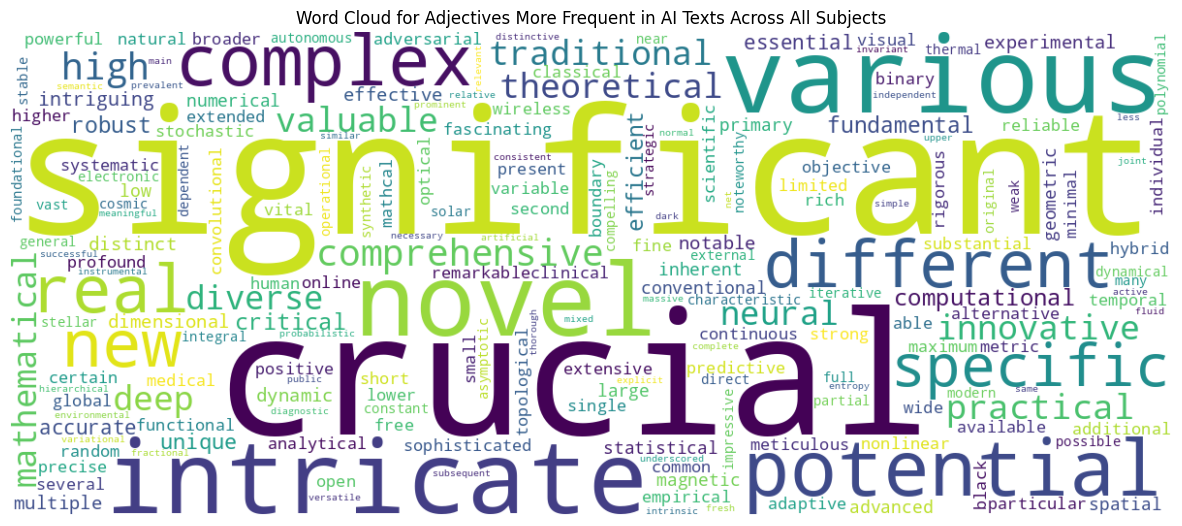

In [12]:
non_adjectives = {'such', 'more', 'least','non','due','current','previous','graphs','average','initial','subject','key','local','dual','total','recent','other'}
# Remove non-adjectives from the dictionary
for word in non_adjectives:
    combined_word_freq.pop(word, None)  # Removes the word if it exists in the dictionary

# After processing all subjects, generate a word cloud based on the combined frequencies.
wordcloud = WordCloud(width=1200, height=500, background_color='white').generate_from_frequencies(combined_word_freq)

# Display the word cloud.
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Adjectives More Frequent in AI Texts Across All Subjects")
plt.show()

significant: 12876
crucial: 12424
various: 12269
intricate: 11425
novel: 11326
potential: 11219
complex: 9813
real: 8420
new: 8298
different: 8063
specific: 7671
comprehensive: 7541
high: 7365
practical: 6684
valuable: 6472
innovative: 6450
traditional: 6404
deep: 6268
theoretical: 6231
neural: 5765
diverse: 5698
mathematical: 5586
computational: 5580
critical: 5548
fundamental: 5306
efficient: 5283
robust: 5145
unique: 4810
essential: 4390
accurate: 4186
intriguing: 3929
dimensional: 3666
effective: 3647
distinct: 3514
notable: 3487
dynamic: 3404
experimental: 3390
multiple: 3351
primary: 3148
low: 2982
advanced: 2939
numerical: 2894
conventional: 2815
statistical: 2797
large: 2784
geometric: 2775
inherent: 2741
spatial: 2650
magnetic: 2600
precise: 2429
sophisticated: 2428
objective: 2384
powerful: 2369
broader: 2346
single: 2316
present: 2288
remarkable: 2267
extensive: 2144
human: 2111
reliable: 2068
medical: 2061
empirical: 2038
random: 2015
particular: 2013
profound: 1986
stochas

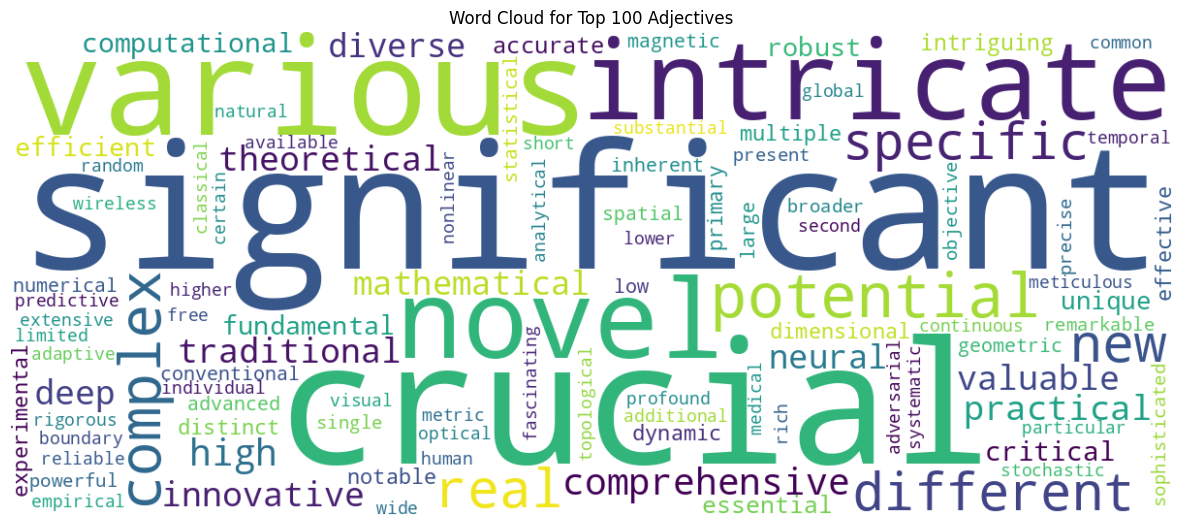

In [13]:
# Sort adjectives by frequency in descending order and get the top 100
top_100_adjectives = sorted(combined_word_freq.items(), key=lambda x: x[1], reverse=True)[:100]

# Create a new dictionary for word cloud input
top_100_adjective_freq = dict(top_100_adjectives)

# Print the top 100 frequent adjectives
for word, freq in top_100_adjectives:
    print(f"{word}: {freq}")

# Generate a word cloud based on these frequencies
wordcloud = WordCloud(width=1200, height=500, background_color='white').generate_from_frequencies(top_100_adjective_freq)

# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Top 100 Adjectives")
plt.show()

In [16]:
list_1 = frequent_ai_words
list_2 = [
    'commendable', 'innovative', 'meticulous', 'intricate', 'notable',
    'versatile', 'noteworthy', 'invaluable', 'pivotal', 'potent',
    'fresh', 'ingenious', 'cogent', 'ongoing', 'tangible',
    'profound', 'methodical', 'laudable', 'lucid', 'appreciable',
    'fascinating', 'adaptable', 'admirable', 'refreshing', 'proficient',
    'intriguing', 'thoughtful', 'credible', 'exceptional', 'digestible',
    'prevalent', 'interpretative', 'remarkable', 'seamless', 'economical',
    'proactive', 'interdisciplinary', 'sustainable', 'optimizable', 'comprehensive',
    'vital', 'pragmatic', 'comprehensible', 'unique', 'fuller',
    'authentic', 'foundational', 'distinctive', 'pertinent', 'valuable',
    'invasive', 'speedy', 'inherent', 'considerable', 'holistic',
    'insightful', 'operational', 'substantial', 'compelling', 'technological',
    'beneficial', 'excellent', 'keen', 'cultural', 'unauthorized',
    'strategic', 'expansive', 'prospective', 'vivid', 'consequential',
    'manageable', 'unprecedented', 'inclusive', 'asymmetrical', 'cohesive',
    'replicable', 'quicker', 'defensive', 'wider', 'imaginative',
    'traditional', 'competent', 'contentious', 'widespread', 'environmental',
    'instrumental', 'substantive', 'creative', 'academic', 'sizeable',
    'extant', 'demonstrable', 'prudent', 'practicable', 'signatory',
    'continental', 'unnoticed', 'automotive', 'minimalistic', 'intelligent'
]

# Convert list_1 to a set for easy lookup
set_1 = set(list_1.keys())
# Convert list_2 to a set
set_2 = set(list_2)

# Find words in list_2 that are not in list_1
words_in_list_2_not_in_list_1 = set_2 - set_1

# Count of words in list_2 not present in list_1
count_not_in_list_1 = len(words_in_list_2_not_in_list_1)
# Find intersection of both sets to determine common words
common_words = set_1.intersection(list_2)

# Count of common words
count_common_words = len(common_words)
count_common_words, common_words,count_not_in_list_1,words_in_list_2_not_in_list_1


(74,
 {'academic',
  'adaptable',
  'authentic',
  'automotive',
  'beneficial',
  'cohesive',
  'commendable',
  'compelling',
  'comprehensible',
  'comprehensive',
  'consequential',
  'considerable',
  'creative',
  'credible',
  'cultural',
  'demonstrable',
  'distinctive',
  'environmental',
  'excellent',
  'exceptional',
  'expansive',
  'fascinating',
  'foundational',
  'fresh',
  'holistic',
  'inclusive',
  'inherent',
  'innovative',
  'insightful',
  'instrumental',
  'intelligent',
  'interdisciplinary',
  'interpretative',
  'intricate',
  'intriguing',
  'invaluable',
  'invasive',
  'keen',
  'manageable',
  'methodical',
  'meticulous',
  'notable',
  'noteworthy',
  'ongoing',
  'operational',
  'pertinent',
  'pivotal',
  'potent',
  'pragmatic',
  'prevalent',
  'proactive',
  'proficient',
  'profound',
  'prospective',
  'quicker',
  'remarkable',
  'seamless',
  'strategic',
  'substantial',
  'substantive',
  'sustainable',
  'tangible',
  'technological',
  

In [17]:
# Convert list_1 to a set for easy lookup
set_1 = set(frequent_ai_words.keys())
set_2 = set(list_2)

# Find intersection and unique words
common_words = set_1.intersection(set_2)
unique_to_list_2 = set_2 - set_1

# Create frequency dictionaries for common words and unique words
common_word_freq = {word: frequent_ai_words[word] for word in common_words}
unique_word_freq = {word: 1 for word in unique_to_list_2}  # Using 1 as frequency for visualization


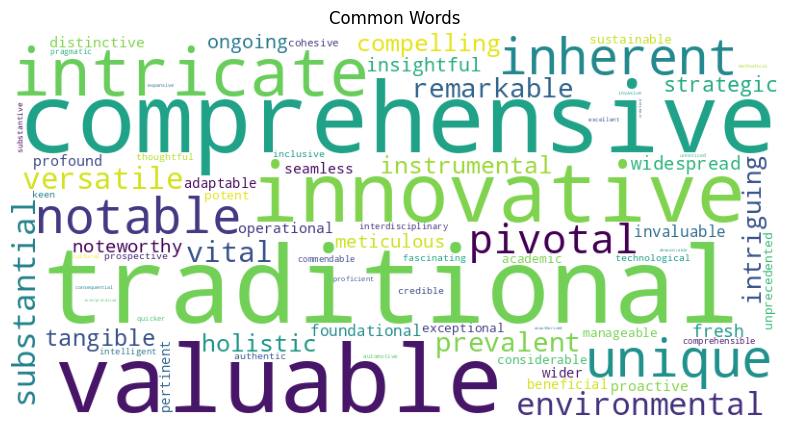

In [33]:
# Generate word cloud for common words
wordcloud_common = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word_freq)

# Generate word cloud for unique words
wordcloud_unique = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_word_freq)

# Display the word clouds
plt.figure(figsize=(10, 5))

# Common words
plt.imshow(wordcloud_common, interpolation='hanning')
plt.axis('off')
plt.title('Common Words')


plt.show()
